In [1]:
import pandas as pd
import numpy as np
from numpy import log
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy import optimize

In [2]:
from numericalunits import W, K, nm, m, cm, s, eV, meV, V, mA, c0, hPlanck, kB, e

In [3]:
fg1 = pd.read_excel('https://www.nrel.gov/grid/solar-resource/assets/data/astmg173.xls')

In [4]:
fg1.columns = ['A','B','C','D']
fg1

,A,B,C,D
0,Wvlgth nm,Etr W*m-2*nm-1,Global tilt W*m-2*nm-1,Direct+circumsolar W*m-2*nm-1
1,280,0.082,0.0,0.0
2,280.5,0.099,0.0,0.0
3,281,0.15,0.0,0.0
4,281.5,0.212,0.0,0.0
...,...,...,...,...
1998,3980,0.00884,0.007387,0.007405
1999,3985,0.0088,0.007433,0.00745
2000,3990,0.00878,0.007372,0.007389
2001,3995,0.0087,0.00721,0.007226


In [5]:
fg2 = fg1.iloc[1:,[0,2]]
fg2

,A,C
1,280,0.0
2,280.5,0.0
3,281,0.0
4,281.5,0.0
5,282,0.0
...,...,...
1998,3980,0.007387
1999,3985,0.007433
2000,3990,0.007372
2001,3995,0.00721


In [6]:
AM15 = np.array(fg2)
AM15 

array([[280, 4.7309e-23],
       [280.5, 1.2307e-21],
       [281, 5.6895e-21],
       ...,
       [3990, 0.0073723],
       [3995, 0.00721],
       [4000, 0.0071043]], dtype=object)

In [7]:
a = AM15[0:,0] # nm
b = AM15[0:,1] # W / m**2 / nm
a = a * nm
b = b * W / m**2 / nm

In [8]:
λ_min = 280 * nm
λ_max = 4000 * nm
E_min = hPlanck * c0 / λ_max
E_max = hPlanck * c0 / λ_min

In [9]:
AM15_interp = interp1d(a,b) 
λs = np.linspace(λ_min ,λ_max , num=500) 
y = np.array([AM15_interp(x) for x in λs]) 

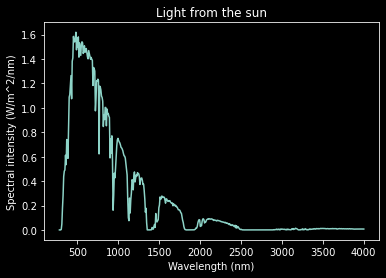

In [10]:
plt.plot(λs / nm ,y / (W / m**2 / nm) )
plt.xlabel("Wavelength (nm)")
plt.ylabel(r"Spectral intensity (W/m^2/nm)")
plt.title("Light from the sun");

In [11]:
def SPhotonsPerTEA(Ephoton): 
    λ = hPlanck * c0 / Ephoton 
    return AM15_interp(λ) * (hPlanck * c0 / Ephoton**2) / Ephoton 
# SPhotonsPerTEA 单位为 光量子数/(m^2*s)/ eV

In [12]:
f = lambda E : SPhotonsPerTEA(E) * E #赋予每个光子对应的电子伏特能量
solar_constant = integrate.quad (f,E_min,E_max,full_output=1)[0]
solar_constant / (W/m**2)
#上一步 SPhotonsPerTEA 求出的就是关于E的纵轴函数
# AM1.5 * λ / E (而λ= hc/E)  
#Solar constant" is the sun's total irradiance. If I did this right, it should be 1000 watts/meter 2

999.9327692139021

In [13]:
def solar_photons_above_gap(Egap):
    return integrate.quad(SPhotonsPerTEA, Egap, E_max, full_output=1)[0]

Text(0, 0.5, 'Photons above bandgap(10^21*m^-2*s^-1) ')

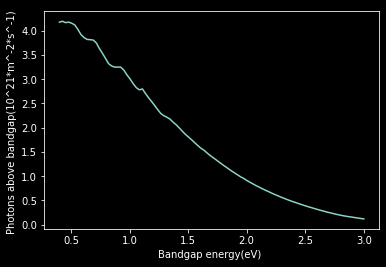

In [14]:
Egap_list1 = np.linspace(0.4 * eV, 3 * eV ,num = 100)
y2 = np.array([solar_photons_above_gap(x) for x in Egap_list1]) 
plt.plot(Egap_list1 / eV , y2/ 10**21 / (m**-2 * s**-1))
plt.xlabel("Bandgap energy(eV) ")
plt.ylabel(r"Photons above bandgap(10^21*m^-2*s^-1) ")

In [15]:
Tcell = 300 * K

In [16]:
def RR0(Egap):
    integrand = lambda E : E**2 / (np.exp(E / (kB * Tcell)) - 1)
    integral = integrate.quad(integrand, Egap, E_max, full_output=1)[0]
    return ((2 * np.pi) / (c0**2 * hPlanck**3)) * integral

In [17]:
def current_density(voltage, Egap):
    return e * (solar_photons_above_gap(Egap) - RR0(Egap) * np.exp(e * voltage / (kB * Tcell)))

In [18]:
# 定义短路电流
def JSC(Egap):
    return current_density(0 , Egap)
#定义开路电压  与饱和光电流有关
# np.log()指代的便是数学中使用的ln函数
def VOC(Egap):
    return (kB * Tcell / e ) * log(solar_photons_above_gap(Egap) / RR0(Egap)+1)

In [19]:
z13 = JSC(1.416  * eV) / (mA / cm**2)
z12 = JSC(1.433 * eV ) / (mA / cm**2)
z11 = JSC(1.493 * eV) / (mA / cm**2)
print(z11)
print(z12)
print(z13)

29.213165953769625
31.522243332777656
32.21804628611975


Text(0.5, 1.0, 'Ideal short-circuit current as a function of bandgap')

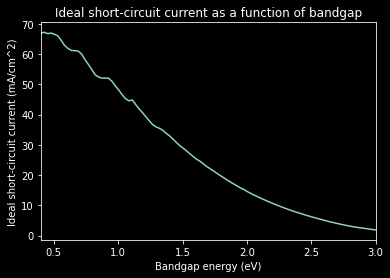

In [20]:
Egap_list2 = np.linspace(0.4 * eV , 3 * eV , num = 100)
y3 = np.array([JSC(x) for x in Egap_list2 ])
plt.plot(Egap_list2 / eV, y3 / (mA / cm**2))
plt.xlim(0.4,3)
plt.xlabel("Bandgap energy (eV)")
plt.ylabel(r"Ideal short-circuit current (mA/cm^2)")
plt.title("Ideal short-circuit current as a function of bandgap")

(0.4, 3.0)

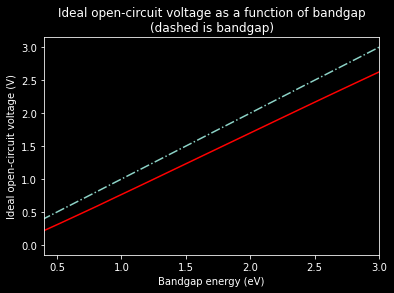

In [21]:
Egap_list3 = np.linspace(0.4 * eV, 3 * eV, num=20)
VOC_list = np.array([VOC(E) for E in Egap_list3])
plt.plot(Egap_list3 / eV , VOC_list / V, color = 'red')
plt.plot(np.linspace(0,3) , np.linspace(0,3), '-.')         
plt.xlabel("Bandgap energy (eV)")
plt.ylabel("Ideal open-circuit voltage (V)")
plt.title("Ideal open-circuit voltage as a function of bandgap\n(dashed is bandgap)")
plt.xlim(0.4,3)

In [24]:
def fmax(func_to_maximize, x0=0):
    func_to_minimize = lambda x : -func_to_maximize(x)
    return optimize.fmin(func_to_minimize, x0, disp=True)[0]

def max_power(Egap):
    f = lambda voltage : voltage * current_density(voltage, Egap)
    a = fmax(f)
    max_power = f(a)
    return max_power
#  返回的是Parameter that minimizes function.
#  要返回最大值fopt
#  Value of function at minimum: fopt = func(xopt).

def max_efficiency(Egap):
    return max_power(Egap) / solar_constant

In [25]:
max_efficiency(1.1 * eV)

/tmp/ipykernel_3004/1611598360.py:2: RuntimeWarning: overflow encountered in exp
  return e * (solar_photons_above_gap(Egap) - RR0(Egap) * np.exp(e * voltage / (kB * Tcell)))


Optimization terminated successfully.
         Current function value: -0.042853
         Iterations: 19
         Function evaluations: 38


0.32925572016701504

/tmp/ipykernel_3004/1611598360.py:2: RuntimeWarning: overflow encountered in exp
  return e * (solar_photons_above_gap(Egap) - RR0(Egap) * np.exp(e * voltage / (kB * Tcell)))


Optimization terminated successfully.
         Current function value: -0.012542
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: -0.014361
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: -0.015829
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: -0.017957
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.019661
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: -0.021335
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: -0.022682
         Iterations: 20
         Function evaluations: 40
Optimization terminated suc

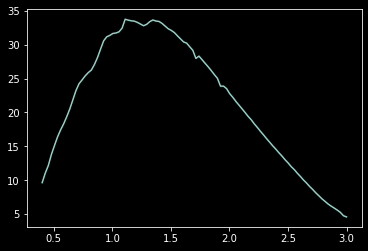

In [26]:
Egap_list4 = np.linspace(0.4 * eV , 3 * eV, num = 100)
efficency = np.array([max_efficiency(x) for x in Egap_list4])
plt.plot(Egap_list4 / eV , efficency * 100)

In [26]:
def FF(Egap):
    return max_power(Egap) / (JSC(Egap) * VOC(Egap))

(0.0, 1.0)

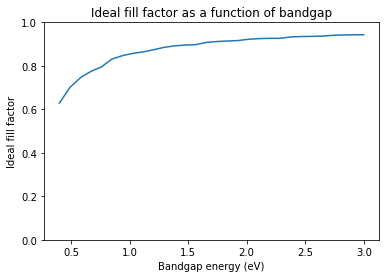

In [30]:
Egap_list5 = np.linspace(0.4 * eV, 3 * eV, num=30)
FF_list = np.array([FF(E) for E in Egap_list5])
plt.plot(Egap_list5 / eV , FF_list)
plt.xlabel("Bandgap energy (eV)")
plt.ylabel("Ideal fill factor")
plt.title("Ideal fill factor as a function of bandgap")
plt.ylim(0,1)